## SCORE NETWORK

In [13]:
import time
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.ndimage.interpolation import rotate
import numpy as np

from IPython.display import HTML
from IPython.display import clear_output
from IPython import display
from colour import Color


torch.manual_seed(0)
np.random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)
torch.backends.cudnn.benchmark = True

class Model(nn.Module):
    def __init__(self, device, n_steps, sigma_min, sigma_max, p=0.5):
        '''
        Score Network.

        n_steps   : perturbation schedule steps (Langevin Dynamic step)
        sigma_min : sigma min of perturbation schedule
        sigma_min : sigma max of perturbation schedule

        '''
        super().__init__()
        self.device = device
        self.sigmas = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = n_steps)).to(device = device)
        
        self.linear_model1 = nn.Sequential(nn.Linear(3, 32),nn.GELU())
        self.embedding_layer = nn.Embedding(n_steps, 32)
        self.norm1 = nn.BatchNorm1d(32, affine=False)
        self.shift = nn.Parameter(torch.zeros(32))
        self.shift.data.normal_(1, 0.02)

        self.linear_model2 = nn.Sequential(nn.Linear(32, 64),nn.Dropout(p),nn.GELU(),
                                           nn.Linear(64, 64),nn.Dropout(p),nn.GELU(),
                                           nn.Linear(64, 3))       
        self.to(device = self.device)
        

    def loss_fn(self, x, idx=None):
        '''
        This function performed when only training phase.

        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.

        '''
        scores, target, sigma = self.forward(x, idx=idx, get_target=True)    
        target = target.view(target.shape[0], -1)
        scores = scores.view(scores.shape[0], -1)
        losses = torch.square(scores - target).mean(dim=-1) * sigma.squeeze() ** 2
        return losses.mean(dim=0)

        
    def forward(self, x, idx=None, get_target=False):
        '''
        x          : real data if idx==None else perturbation data
        idx        : if None (training phase), we perturbed random index. Else (inference phase), it is recommended that you specify.
        get_target : if True (training phase), target and sigma is returned with output (score prediction)

        '''
        if idx == None:
            idx = torch.randint(0, len(self.sigmas), (x.size(0),)).to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            noise = torch.randn_like(x)
            x_tilde = x + noise * used_sigmas
            
        else:
            idx = torch.cat([torch.Tensor([idx for _ in range(x.size(0))])]).long().to(device = self.device)
            used_sigmas = self.sigmas[idx][:,None]
            x_tilde = x

        if get_target:
            target = - 1 / used_sigmas * noise

        output = self.linear_model1(x_tilde)
        #embedding = self.embedding_layer(idx)
        #output = self.linear_model2(output + embedding)
        output = self.norm1(output)
        output = output + self.shift.view(1,-1).repeat(output.shape[0],1)
        output = self.linear_model2(output)
        output = output / used_sigmas

        return (output, target, used_sigmas) if get_target else output

## ANNEALED LANGEVIN DYNAMICS MCMC SAMPLER

In [14]:
class AnnealedLangevinDynamic():
    def __init__(self, sigma_min, sigma_max, L, T, score_fn, device, eps = 1e-1):
        '''
        sigma_min : minimum sigmas of perturbation schedule 
        sigma_max : maximum sigmas of perturbation schedule 
        L         : iteration step of Langevin dynamic
        T         : annelaed step of annealed Langevin dynamic
        score_fn  : trained score network
        eps       : coefficient of step size
        '''

        self.process = torch.exp(torch.linspace(start=math.log(sigma_max), end=math.log(sigma_min), steps = L))
        self.step_size = eps * (self.process / self.process[-1] ) ** 2
        self.score_fn = score_fn
        self.annealed_step = T
        self.device = device

    def _one_annealed_step_iteration(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        self.score_fn.eval()
        z, step_size = torch.randn_like(x).to(device = self.device), self.step_size[idx]
        x = x + 0.5 * step_size * self.score_fn(x, idx) + torch.sqrt(step_size) * z
        return x

    def _one_annealed_step(self, x, idx):
        '''
        x   : perturbated data
        idx : step of perturbation schedule
        '''
        for _ in range(self.annealed_step):
            x = self._one_annealed_step_iteration(x, idx)
        return x

    def _one_perturbation_step(self, x):
        '''
        x   : sampling of prior distribution
        '''
        for idx in range(len(self.process)):
            x = self._one_annealed_step(x, idx)
            yield x
    
    @torch.no_grad()
    def sampling(self, sampling_number, only_final=False):
        '''
        only_final : If True, return is an only output of final schedule step 
        '''
        sample = (torch.rand([sampling_number,3]).to(device = self.device) - 0.5)*2
        sampling_list = []
        
        final = None
        for sample in self._one_perturbation_step(sample):
            final = sample
            if not only_final:
                sampling_list.append(final)
                

        return final if only_final else torch.stack(sampling_list)

## UTILITY FUNCTIONS

In [15]:
class AverageMeter(object):
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self. count += n
        self.avg = self.sum / self.count
    
    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        
        print('\r' + '\t'.join(entries), end = '')

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'
    
def scatter(sample, only_final, scatter_range = [-10, 10], title=None, save_name=None):
    clear_output()
    if only_final:
        scatter = sample.detach().cpu().numpy()
        scatter_x, scatter_y, scatter_z = scatter[:,0], scatter[:,1], scatter[:,2]
        
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(projection='3d')

        ax.set_xlim(scatter_range)
        ax.set_ylim(scatter_range)
        ax.set_zlim([0, 80])

        plt.rc('axes', unicode_minus=False)
        ax.scatter(scatter_x, scatter_y, scatter_z, s=10)
        if title:
            plt.title(title)
        if save_name:
            plt.savefig(save_name)
        plt.show()
    
    else:
        step_size = sample.size(0)
        fig = plt.figure(figsize=(step_size * 4, 4), constrained_layout = True)
        
        for i in range(step_size):
            axs = fig.add_subplot(1, step_size, i+1, projection='3d')
            scatter = sample[i].detach().cpu().numpy()
            scatter_x, scatter_y, scatter_z = scatter[:,0], scatter[:,1], scatter[:,2]
            axs.scatter(scatter_x, scatter_y, scatter_z, s=10)
            axs.set_xlim(scatter_range)
            axs.set_ylim(scatter_range)
            axs.set_zlim([0,80])
        if title:
            plt.title(title)
        if save_name:
            plt.savefig(save_name)
        plt.show()
     

def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val*255)), "02x") for val in item]) for item in rgb_colors]


## DATA LOADER

In [16]:
class DataSet(torch.utils.data.Dataset):
    def __init__(self, total_len = 1000000):
        self.total_len = total_len
        self.data = torch.zeros((total_len, 3))
        for i in range(total_len):
            self.data[i,2] = 100.0*torch.rand(1)
            self.data[i,1] = 5.0*torch.sin(0.25*self.data[i,2]) + 0.2*torch.randn(1)
            self.data[i,0] = 5.0*torch.cos(0.25*self.data[i,2]) + 0.2*torch.randn(1)
        
    def __len__(self):
        return self.total_len
    
    def __getitem__(self, idx):
        data = self.data[idx]
        return data

## HYPERPARAMETERS

In [17]:
eps = 1e-6
sigma_min = 0.001
sigma_max = 50
n_steps = 10
annealed_step = 100
device = torch.device('cuda')
model = Model(device, n_steps, sigma_min, sigma_max, p = 0.3)
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)

scatter_range = [-10, 10]
total_iteration = 150000
display_iteration = 7500
sampling_number = 1000
only_final = True
losses = AverageMeter('Loss', ':.4f')
progress = ProgressMeter(total_iteration, [losses], prefix='Iteration ')

## CREATE AND PLOT TRAINING DATA

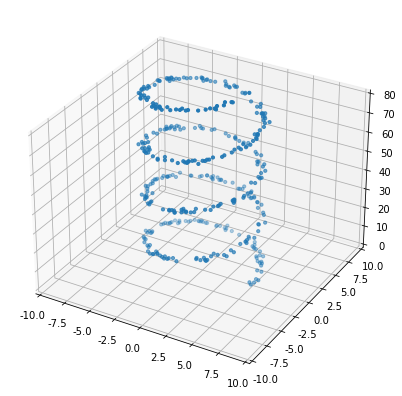

In [18]:
batch_size = 128
dataset = DataSet(total_len=400)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, drop_last = True)
dataiterator = iter(dataloader)

xx = [dataset.__getitem__(i) for i in range(len(dataset))]
xx = torch.stack(xx, dim=0)
scatter(xx, True, save_name='./toy3d/dataset.jpg')

## TRAINING

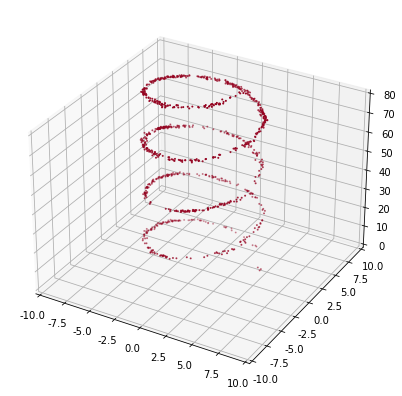

In [19]:
flag = 0
current_iteration = 0
red = Color("red")

color1 = "#8A5AC2"
color2 = "#960019"
color = get_color_gradient(color1, color2, int(total_iteration/display_iteration) + 2)

while current_iteration != total_iteration:
    try:
        data = dataiterator.next()
    except:
        dataiterator = iter(dataloader)
        data = dataiterator.next()
    data = data.to(device = device)
    loss = model.loss_fn(data)

    optim.zero_grad()
    loss.backward()
    optim.step()

    losses.update(loss.item())
    progress.display(current_iteration)
    
    current_iteration += 1
    
    if current_iteration % display_iteration == 0:
        dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
        sample = dynamic.sampling(sampling_number, only_final)
        clear_output(wait=True)
        fig = plt.figure(figsize=(7, 7))
        ax = fig.add_subplot(projection='3d')
        ax.set_xlim(scatter_range)
        ax.set_ylim(scatter_range)
        ax.set_zlim([0, 80])
        plt.rc('axes', unicode_minus=False)
        ax.scatter(sample[:,0].detach().cpu().numpy(), sample[:,1].detach().cpu().numpy(), sample[:,2].detach().cpu().numpy(), s=1, c=color[int(current_iteration/display_iteration)])
        plt.savefig("./toy3d/images_" + str(current_iteration) + ".jpg")
        plt.show()
        #display.display(plt.gcf())
        #time.sleep(1)
        #time.sleep(4)
        #plt.cla() 


## SAMPLING

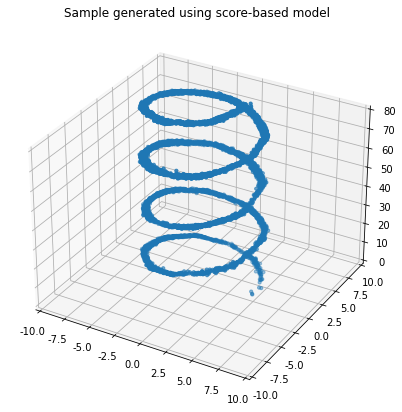

In [20]:

sampling_number = 10000
only_final = True
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
scatter(sample, only_final, scatter_range= scatter_range,title=r'Sample generated using score-based model', save_name='./toy3d/'+'fake.jpg')

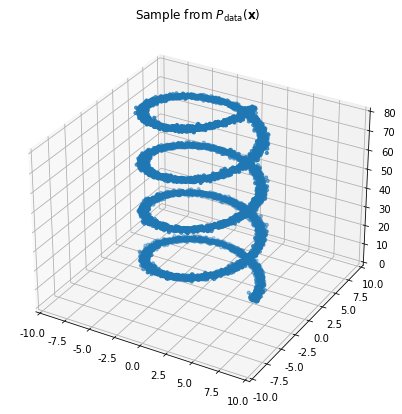

In [21]:
dataset2 = DataSet(total_len=10000)
dataloader2 = torch.utils.data.DataLoader(dataset2, batch_size = batch_size, drop_last = True)
dataiterator2 = iter(dataloader2)
xx = [dataset2.__getitem__(i) for i in range(len(dataset2))]
xx = torch.stack(xx, dim=0)
scatter(xx, True, title=r'Sample from $P_{\mathrm{data}}(\mathbf{x})$', save_name='./toy3d/'+'real.jpg')

In [22]:
from mpl_toolkits.mplot3d import Axes3D

def update_plot(i, data, scat):
    scat._offsets3d = (data[i,:,0].detach().cpu().numpy(),data[i,:,1].detach().cpu().numpy(),data[i,:,2].detach().cpu().numpy())
    return scat

sampling_number = 10000
only_final = False
dynamic = AnnealedLangevinDynamic(sigma_min, sigma_max, n_steps, annealed_step, model, device, eps=eps)
sample = dynamic.sampling(sampling_number, only_final)
scatter(sample, only_final, scatter_range=scatter_range)

numframes = len(sample)
scatter_point = sample[0].detach().cpu().numpy()
scatter_x, scatter_y, scatter_z = scatter_point[:,0], scatter_point[:,1], scatter_point[:,2]

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(scatter_range)
ax.set_ylim(scatter_range)
ax.set_zlim([0,80])

scat = ax.scatter(scatter_x, scatter_y, scatter_z, s=1)
plt.show()
clear_output()

ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes), fargs=(sample, scat), interval=1000)
ani.save('./toy3d/toy3d.gif')
HTML(ani.to_jshtml())